<a href="https://colab.research.google.com/github/sm60786/Beans-Image-Classification-1/blob/main/Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from IPython.display import Image, display

In [2]:
!nvidia-smi

Fri Dec  9 20:29:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P0    26W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://storage.googleapis.com/ibeans/train.zip
!wget https://storage.googleapis.com/ibeans/validation.zip
!wget https://storage.googleapis.com/ibeans/test.zip

--2022-12-09 20:30:43--  https://storage.googleapis.com/ibeans/train.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 143812152 (137M) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>] 137.15M  15.0MB/s    in 10s     

2022-12-09 20:30:55 (13.2 MB/s) - ‘train.zip’ saved [143812152/143812152]

--2022-12-09 20:30:55--  https://storage.googleapis.com/ibeans/validation.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18504213 (18M) [application/zip]
Saving to: ‘validation.zip’

validation.zip      100%[===================>]  17.6

In [4]:
!mkdir beans

In [5]:
!unzip train.zip -d beans/
!unzip test.zip -d beans/
!unzip validation.zip -d beans/

Archive:  train.zip
   creating: beans/train/
   creating: beans/train/healthy/
   creating: beans/train/angular_leaf_spot/
   creating: beans/train/bean_rust/
  inflating: beans/train/healthy/healthy_train.265.jpg  
  inflating: beans/train/healthy/healthy_train.271.jpg  
  inflating: beans/train/healthy/healthy_train.259.jpg  
  inflating: beans/train/healthy/healthy_train.99.jpg  
  inflating: beans/train/healthy/healthy_train.311.jpg  
  inflating: beans/train/healthy/healthy_train.66.jpg  
  inflating: beans/train/healthy/healthy_train.72.jpg  
  inflating: beans/train/healthy/healthy_train.305.jpg  
  inflating: beans/train/healthy/healthy_train.339.jpg  
  inflating: beans/train/healthy/healthy_train.113.jpg  
  inflating: beans/train/healthy/healthy_train.107.jpg  
  inflating: beans/train/healthy/healthy_train.106.jpg  
  inflating: beans/train/healthy/healthy_train.112.jpg  
  inflating: beans/train/healthy/healthy_train.338.jpg  
  inflating: beans/train/healthy/healthy_trai

In [11]:
!ls beans

test  train  validation


In [13]:
!find beans -type f | wc -l

1296


In [14]:
!find beans/test -type f | wc -l

128


In [15]:
!find beans/validation -type f | wc -l

133


In [16]:
!find beans/train -type f | wc -l

1035


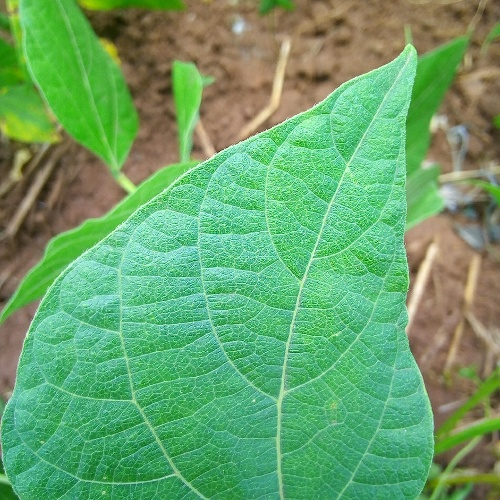

In [19]:
display(Image('beans/train/healthy/healthy_train.0.jpg'))

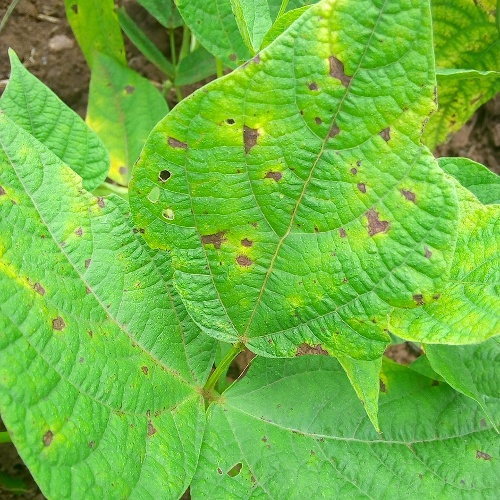

In [25]:
display(Image('beans/train/angular_leaf_spot/angular_leaf_spot_train.210.jpg'))

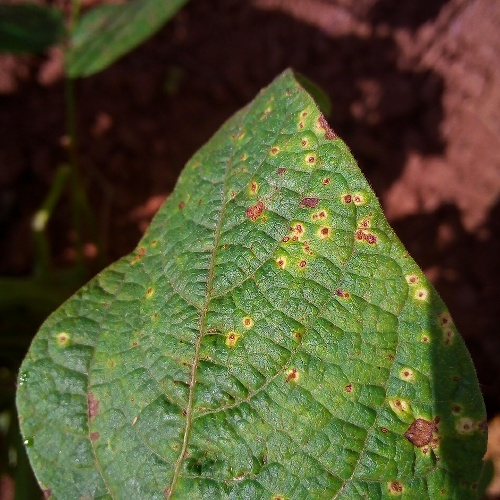

In [33]:
display(Image('beans/train/bean_rust/bean_rust_train.15.jpg'))

In [34]:
batch_size = 128
img_height = 224
img_width = 224

train_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/train', seed=111, image_size=(img_height, img_width), batch_size=batch_size)
test_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/test', seed=111, image_size=(img_height, img_width), batch_size=batch_size)
val_ds = tf.keras.preprocessing.image_dataset_from_directory('beans/validation', seed=111, image_size=(img_height, img_width), batch_size=batch_size)

Found 1034 files belonging to 3 classes.
Found 128 files belonging to 3 classes.
Found 133 files belonging to 3 classes.


In [36]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(128, 224, 224, 3)
(128,)


In [39]:
classes = train_ds.class_names
print(classes)

['angular_leaf_spot', 'bean_rust', 'healthy']


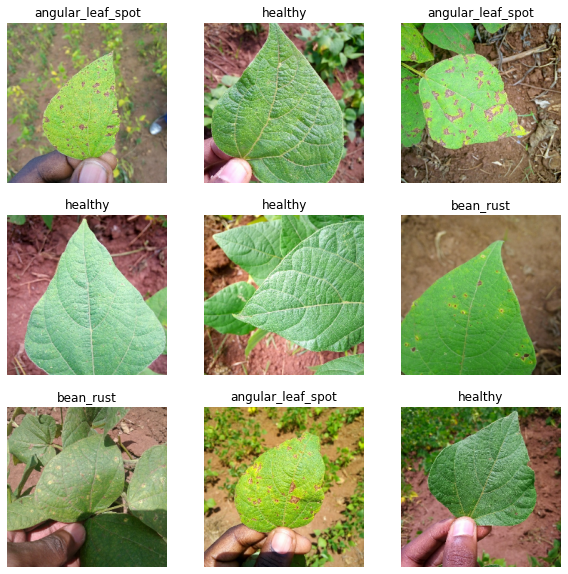

In [41]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(classes[labels[i]])
    plt.axis('off')

In [42]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [43]:
feature_extractor = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

feature_extractor_layer = hub.KerasLayer(feature_extractor, input_shape=(img_height, img_width, 3))

feature_extractor_layer.trainable = False

In [44]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

tf.random.set_seed(111)

In [49]:
model = tf.keras.Sequential([normalization_layer, feature_extractor_layer, tf.keras.layers.Dropout(0.3), tf.keras.layers.Dense(3, activation='softmax')])

model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [50]:
history = model.fit(train_ds, epochs=20, validation_data=val_ds)

Epoch 1/20
9/9 [==============================] - 7s 325ms/step - loss: 1.0922 - accuracy: 0.4613 - val_loss: 0.8195 - val_accuracy: 0.6541
Epoch 2/20
9/9 [==============================] - 1s 151ms/step - loss: 0.8167 - accuracy: 0.6373 - val_loss: 0.6352 - val_accuracy: 0.7368
Epoch 3/20
9/9 [==============================] - 1s 149ms/step - loss: 0.6104 - accuracy: 0.7592 - val_loss: 0.5372 - val_accuracy: 0.7820
Epoch 4/20
9/9 [==============================] - 1s 166ms/step - loss: 0.5612 - accuracy: 0.7611 - val_loss: 0.4794 - val_accuracy: 0.8120
Epoch 5/20
9/9 [==============================] - 1s 169ms/step - loss: 0.4898 - accuracy: 0.7872 - val_loss: 0.4366 - val_accuracy: 0.8271
Epoch 6/20
9/9 [==============================] - 1s 154ms/step - loss: 0.4566 - accuracy: 0.8104 - val_loss: 0.4056 - val_accuracy: 0.8421
Epoch 7/20
9/9 [==============================] - 2s 175ms/step - loss: 0.4327 - accuracy: 0.8240 - val_loss: 0.3822 - val_accuracy: 0.8496
Epoch 8/20
9/9 [====

In [51]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


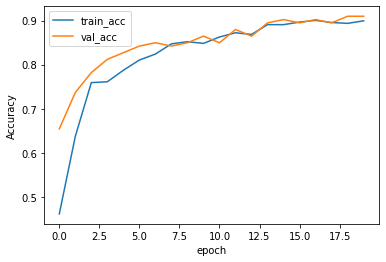

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel("Accuracy")
plt.xlabel('epoch')
plt.legend(['train_acc', 'val_acc'], loc='best')
plt.show()

In [57]:
result = model.evaluate(test_ds)

1/1 [==============================] - 0s 498ms/step - loss: 0.2728 - accuracy: 0.8906


1/1 [==============================] - 0s 19ms/step


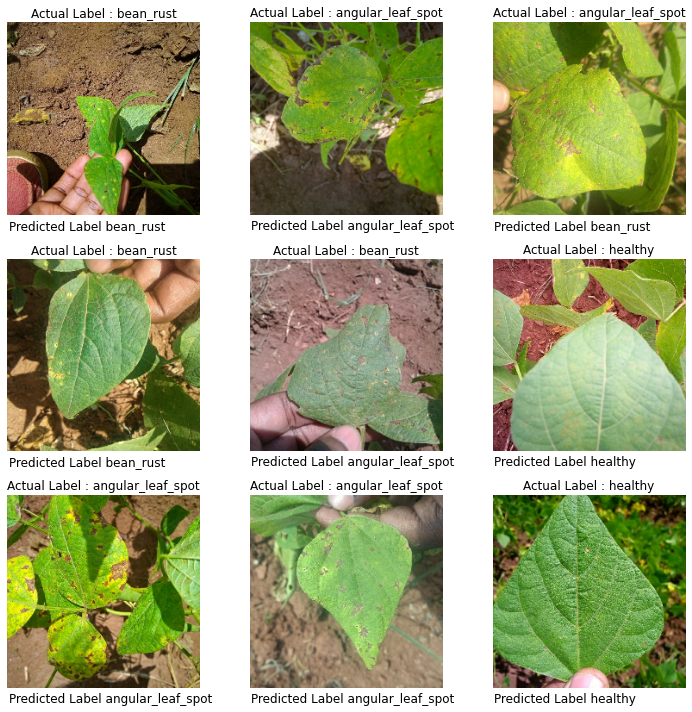

In [58]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)

    plt.tight_layout()

    img = tf.keras.preprocessing.image.img_to_array(images[i])
    img = np.expand_dims(img, axis=0)

    pred = model.predict(img)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title("Actual Label : %s" % classes[labels[i]])
    plt.text(1, 240, "Predicted Label %s" % classes[np.argmax(pred)], fontsize=12)

    plt.axis('off')

In [59]:
model.save('./models', save_format='tf')

In [64]:
!ls -lrt models/

total 1880
drwxr-xr-x 2 root root    4096 Dec  9 21:02 variables
drwxr-xr-x 2 root root    4096 Dec  9 21:02 assets
-rw-r--r-- 1 root root 1908201 Dec  9 21:02 saved_model.pb
-rw-r--r-- 1 root root    6944 Dec  9 21:02 keras_metadata.pb


In [65]:
model_loaded = tf.keras.models.load_model('./models/')

In [66]:
model_loaded.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [67]:
from PIL import Image
from skimage import transform

def process(filename):
  np_image = Image.open(filename)
  np_image = np.array(np_image).astype('float32')
  np_image = transform.resize(np_image, (224, 224, 3))
  np_image = np.expand_dims(np_image, axis=0)
  return np_image

In [68]:
pred_label = model_loaded.predict(process('beans/train/healthy/healthy_train.0.jpg'))
print(classes[np.argmax(pred_label)])

1/1 [==============================] - 0s 452ms/step
healthy


In [74]:
pred_label

array([[5.7565188e-04, 5.8347635e-02, 9.4107670e-01]], dtype=float32)

In [70]:
!zip -r models.zip models/

  adding: models/ (stored 0%)
  adding: models/assets/ (stored 0%)
  adding: models/keras_metadata.pb (deflated 82%)
  adding: models/variables/ (stored 0%)
  adding: models/variables/variables.index (deflated 78%)
  adding: models/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: models/saved_model.pb (deflated 92%)


In [75]:
print(tf.__version__)

2.9.2
